# <center>Advanced Machine Learning, Spring 2023</center>
### <center>Home Assignment 1 – Unsupervised Learning</center>


In [1]:
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

2023-04-22 16:28:20.451589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings

warnings.filterwarnings('ignore')

<br></br>
## Part 0 - MNIST

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [4]:
vals, counts = np.unique(train_y, return_counts=True)
print(pd.DataFrame({'Label': vals, 'Counts': counts, 'Ratio': counts / len(train_X) * 100}).set_index('Label'))
print('')

       Counts      Ratio
Label                   
0        5923   9.871667
1        6742  11.236667
2        5958   9.930000
3        6131  10.218333
4        5842   9.736667
5        5421   9.035000
6        5918   9.863333
7        6265  10.441667
8        5851   9.751667
9        5949   9.915000



In [ ]:
RANDOM_STATE = 42

In [5]:
def downsample(X, y, n):
    labels = np.unique(y)
    new_X = []
    new_y = []
    for label in labels:
        class_samples = X[y == label]
        idx = np.random.choice(range(len(class_samples)), n, replace=False)
        new_X.extend(class_samples[idx])
        new_y.extend(np.tile(label, n))

    new_X, new_y = np.array(new_X), np.array(new_y)
    return new_X, new_y

In [6]:
train_X, train_y = downsample(train_X, train_y, 500)
test_X, test_y = downsample(test_X, test_y, 100)
train_X.shape, test_X.shape

((5000, 28, 28), (1000, 28, 28))

In [7]:
vals, counts = np.unique(train_y, return_counts=True)
print(pd.DataFrame({'Label': vals, 'Counts': counts, 'Ratio': counts / len(train_X) * 100}).set_index('Label'))
print('')

       Counts  Ratio
Label               
0         500   10.0
1         500   10.0
2         500   10.0
3         500   10.0
4         500   10.0
5         500   10.0
6         500   10.0
7         500   10.0
8         500   10.0
9         500   10.0



<br></br>
## Part 1: Clustering

In [8]:
def flatten(X):
    n, h, w = X.shape
    return X.reshape((n, h * w))

In [9]:
def plot_samples(X, y, pred, n_samples=5):
    fig, vAxes = plt.subplots(n_samples, len(np.unique(pred)), figsize=(30, 13))
    for cluster in np.unique(pred):
        instances, labels = X[pred == cluster], y[pred == cluster]
        samples = np.random.choice(range(instances.shape[0]), n_samples)
        samples_labels = labels[samples]

        for i in range(n_samples):
            vAxes[i][cluster].imshow(instances[samples[i]])
            vAxes[i][cluster].set(xlabel=f'class={samples_labels[i]}')
        vAxes[0][cluster].set(title=f'cluster {cluster}\nselected samples')

    plt.tight_layout()
    plt.show()

In [10]:
class ClusteringClassifier:
    def __init__(self):
        self.cluster_labels = None

    def fit_predict(self, y, clusters):
        cluster_labels = {}
        for cluster in np.unique(clusters):
            labels = y[clusters == cluster]
            label, count = np.unique(labels, return_counts=True)
            cluster_labels[cluster] = label[np.argmax(count)]

        self.cluster_labels = cluster_labels
        return np.array([cluster_labels[cluster] for cluster in clusters])

In [11]:
def plot_silhouette_scores(X, clusters):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (10 + 1) * 10])
    silhouette_avg = silhouette_score(flatten(X), clusters)
    print(
        "For n_clusters =",
        10,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(flatten(X), clusters)

    y_lower = 10
    for i in range(10):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / 10)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.linspace(-1, 1, 10))
    plt.suptitle(
        "Silhouette analysis for clustering on sample data with n_clusters = %d"
        % 10,
        fontsize=14,
        fontweight="bold",
    )


In [12]:
def run_experiment(model, X, y, verbose=False):
    # fit the model on train_X
    X_flat = flatten(X)
    clusters = model.fit_predict(X_flat)

    # fit a classifier according to the clustering results and evaluate
    classifier = ClusteringClassifier()
    class_pred = classifier.fit_predict(y, clusters)
    print('classification report:\n', classification_report(y, class_pred))
    print('clusters labels assignments:\n', classifier.cluster_labels)

    if verbose:
        # plot k samples with predicted cluster and true labels
        plot_samples(X, y, clusters)

        # print silhouette_score of train clustering
        plot_silhouette_scores(X, clusters)

        # print classifier confusion_matrix
        conf_matrix = confusion_matrix(y, class_pred, normalize='true')
        _, ax = plt.subplots(1, 1, figsize=(7, 7))
        sns.heatmap(conf_matrix, ax=ax, annot=True)
        ax.set(xlabel='pred', ylabel='label', title='Classifier Confusion Matrix')

### KMeans


classification report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       500
           1       0.59      0.98      0.74       500
           2       0.89      0.72      0.80       500
           3       0.51      0.67      0.58       500
           4       0.44      0.40      0.42       500
           5       0.00      0.00      0.00       500
           6       0.87      0.78      0.82       500
           7       0.37      0.44      0.40       500
           8       0.57      0.59      0.58       500
           9       0.35      0.44      0.39       500

    accuracy                           0.58      5000
   macro avg       0.55      0.58      0.56      5000
weighted avg       0.55      0.58      0.56      5000

clusters labels assignments:
 {0: 0, 1: 9, 2: 1, 3: 3, 4: 6, 5: 7, 6: 8, 7: 0, 8: 4, 9: 2}


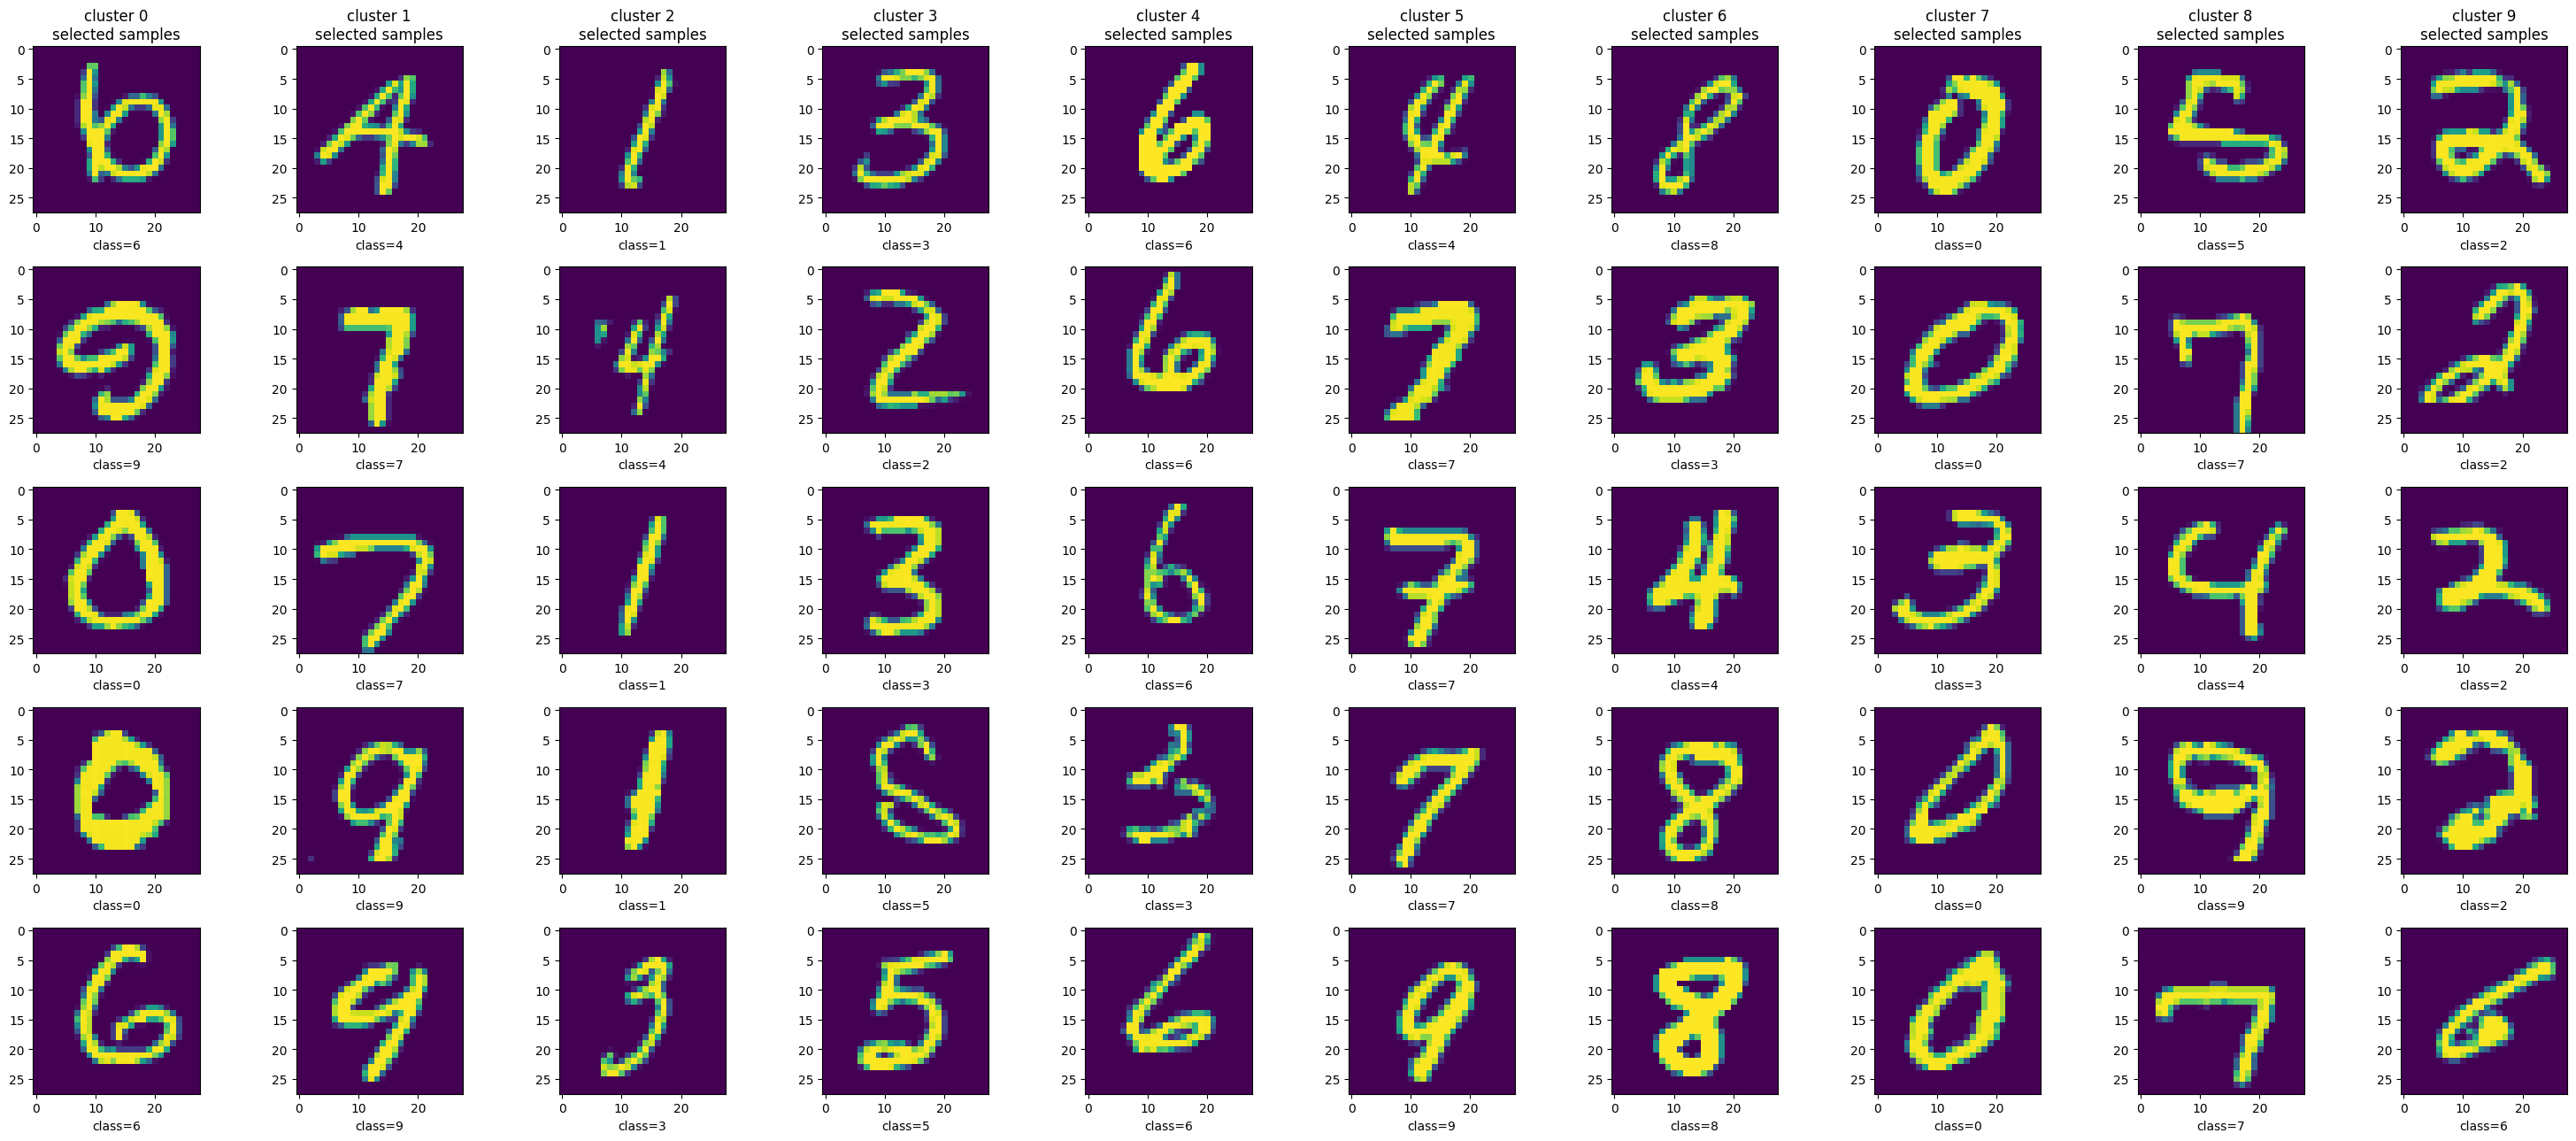

For n_clusters = 10 The average silhouette_score is : 0.07055589850547915


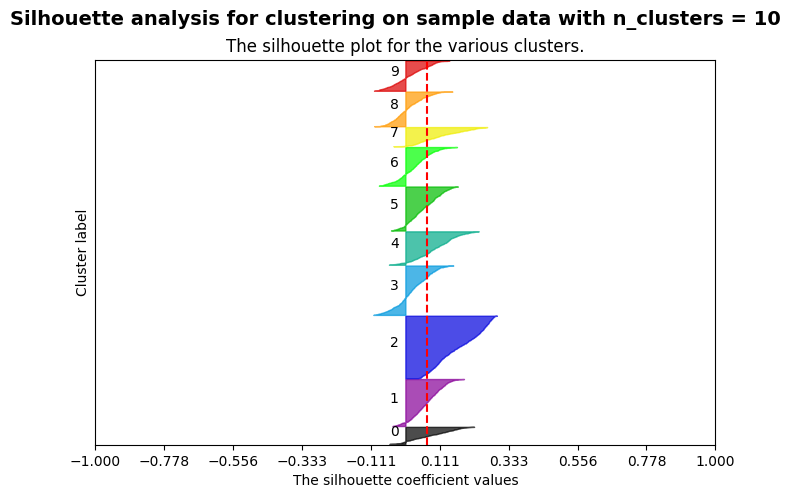

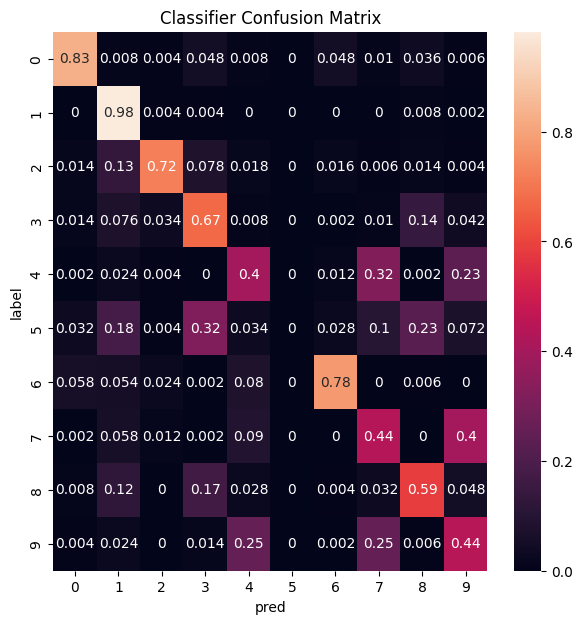

In [13]:
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=3)
run_experiment(kmeans, train_X, train_y, verbose=True)

### Agglomerative Clustering

classification report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82       500
           1       0.98      0.97      0.97       500
           2       0.94      0.94      0.94       500
           3       0.65      0.76      0.70       500
           4       0.49      0.65      0.56       500
           5       0.00      0.00      0.00       500
           6       0.73      0.97      0.83       500
           7       0.55      0.93      0.69       500
           8       0.48      0.85      0.61       500
           9       0.00      0.00      0.00       500

    accuracy                           0.68      5000
   macro avg       0.58      0.68      0.61      5000
weighted avg       0.58      0.68      0.61      5000

clusters labels assignments:
 {0: 1, 1: 8, 2: 0, 3: 6, 4: 7, 5: 3, 6: 2, 7: 7, 8: 6, 9: 4}


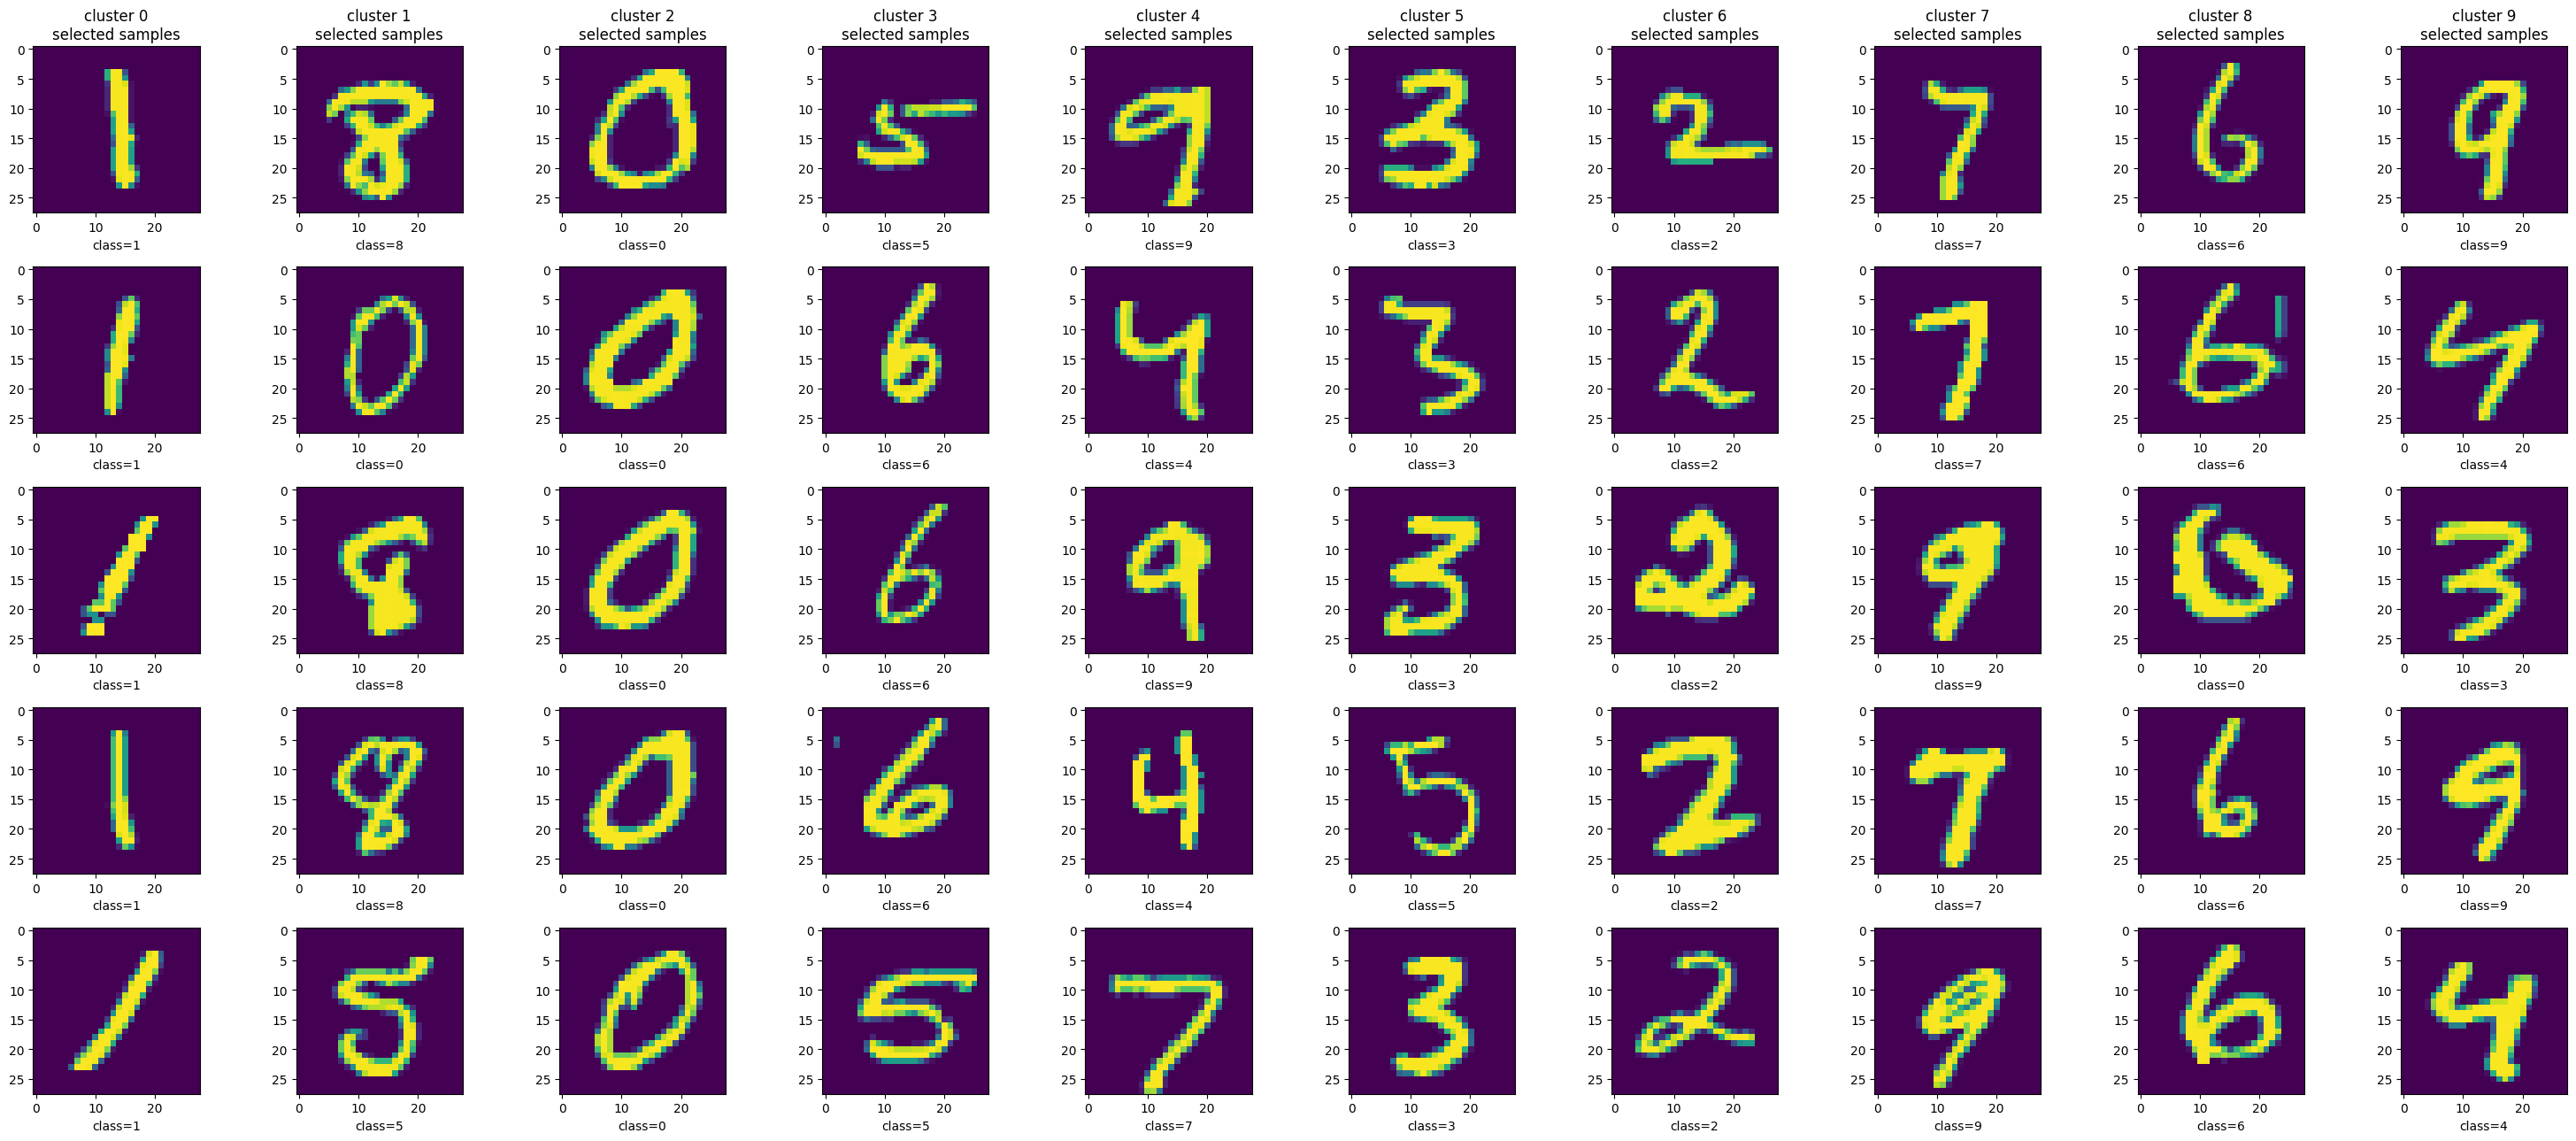

For n_clusters = 10 The average silhouette_score is : 0.04019052655505619


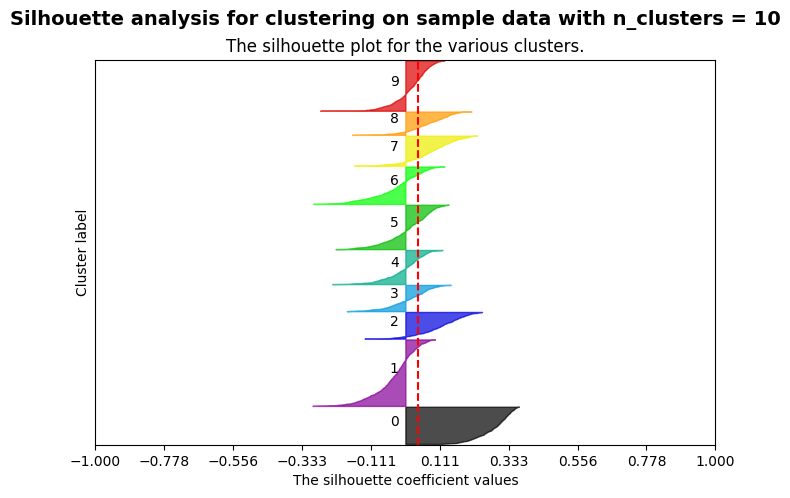

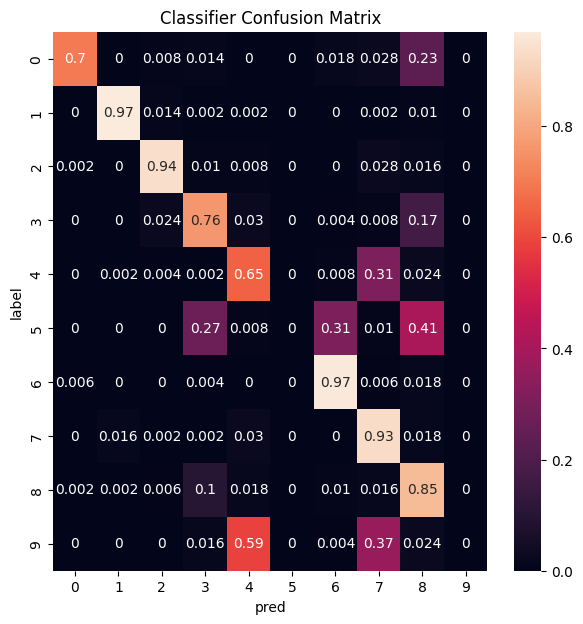

In [14]:
aggl = AgglomerativeClustering(n_clusters=10)
run_experiment(aggl, train_X, train_y, verbose=True)

### MiniBatchKMeans Clustering

classification report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       500
           1       0.64      0.95      0.77       500
           2       0.48      0.42      0.45       500
           3       0.49      0.58      0.53       500
           4       0.38      0.43      0.41       500
           5       0.00      0.00      0.00       500
           6       0.65      0.54      0.59       500
           7       0.49      0.51      0.50       500
           8       0.58      0.56      0.57       500
           9       0.23      0.30      0.26       500

    accuracy                           0.52      5000
   macro avg       0.47      0.52      0.49      5000
weighted avg       0.47      0.52      0.49      5000

clusters labels assignments:
 {0: 4, 1: 7, 2: 6, 3: 3, 4: 1, 5: 0, 6: 2, 7: 8, 8: 0, 9: 9}


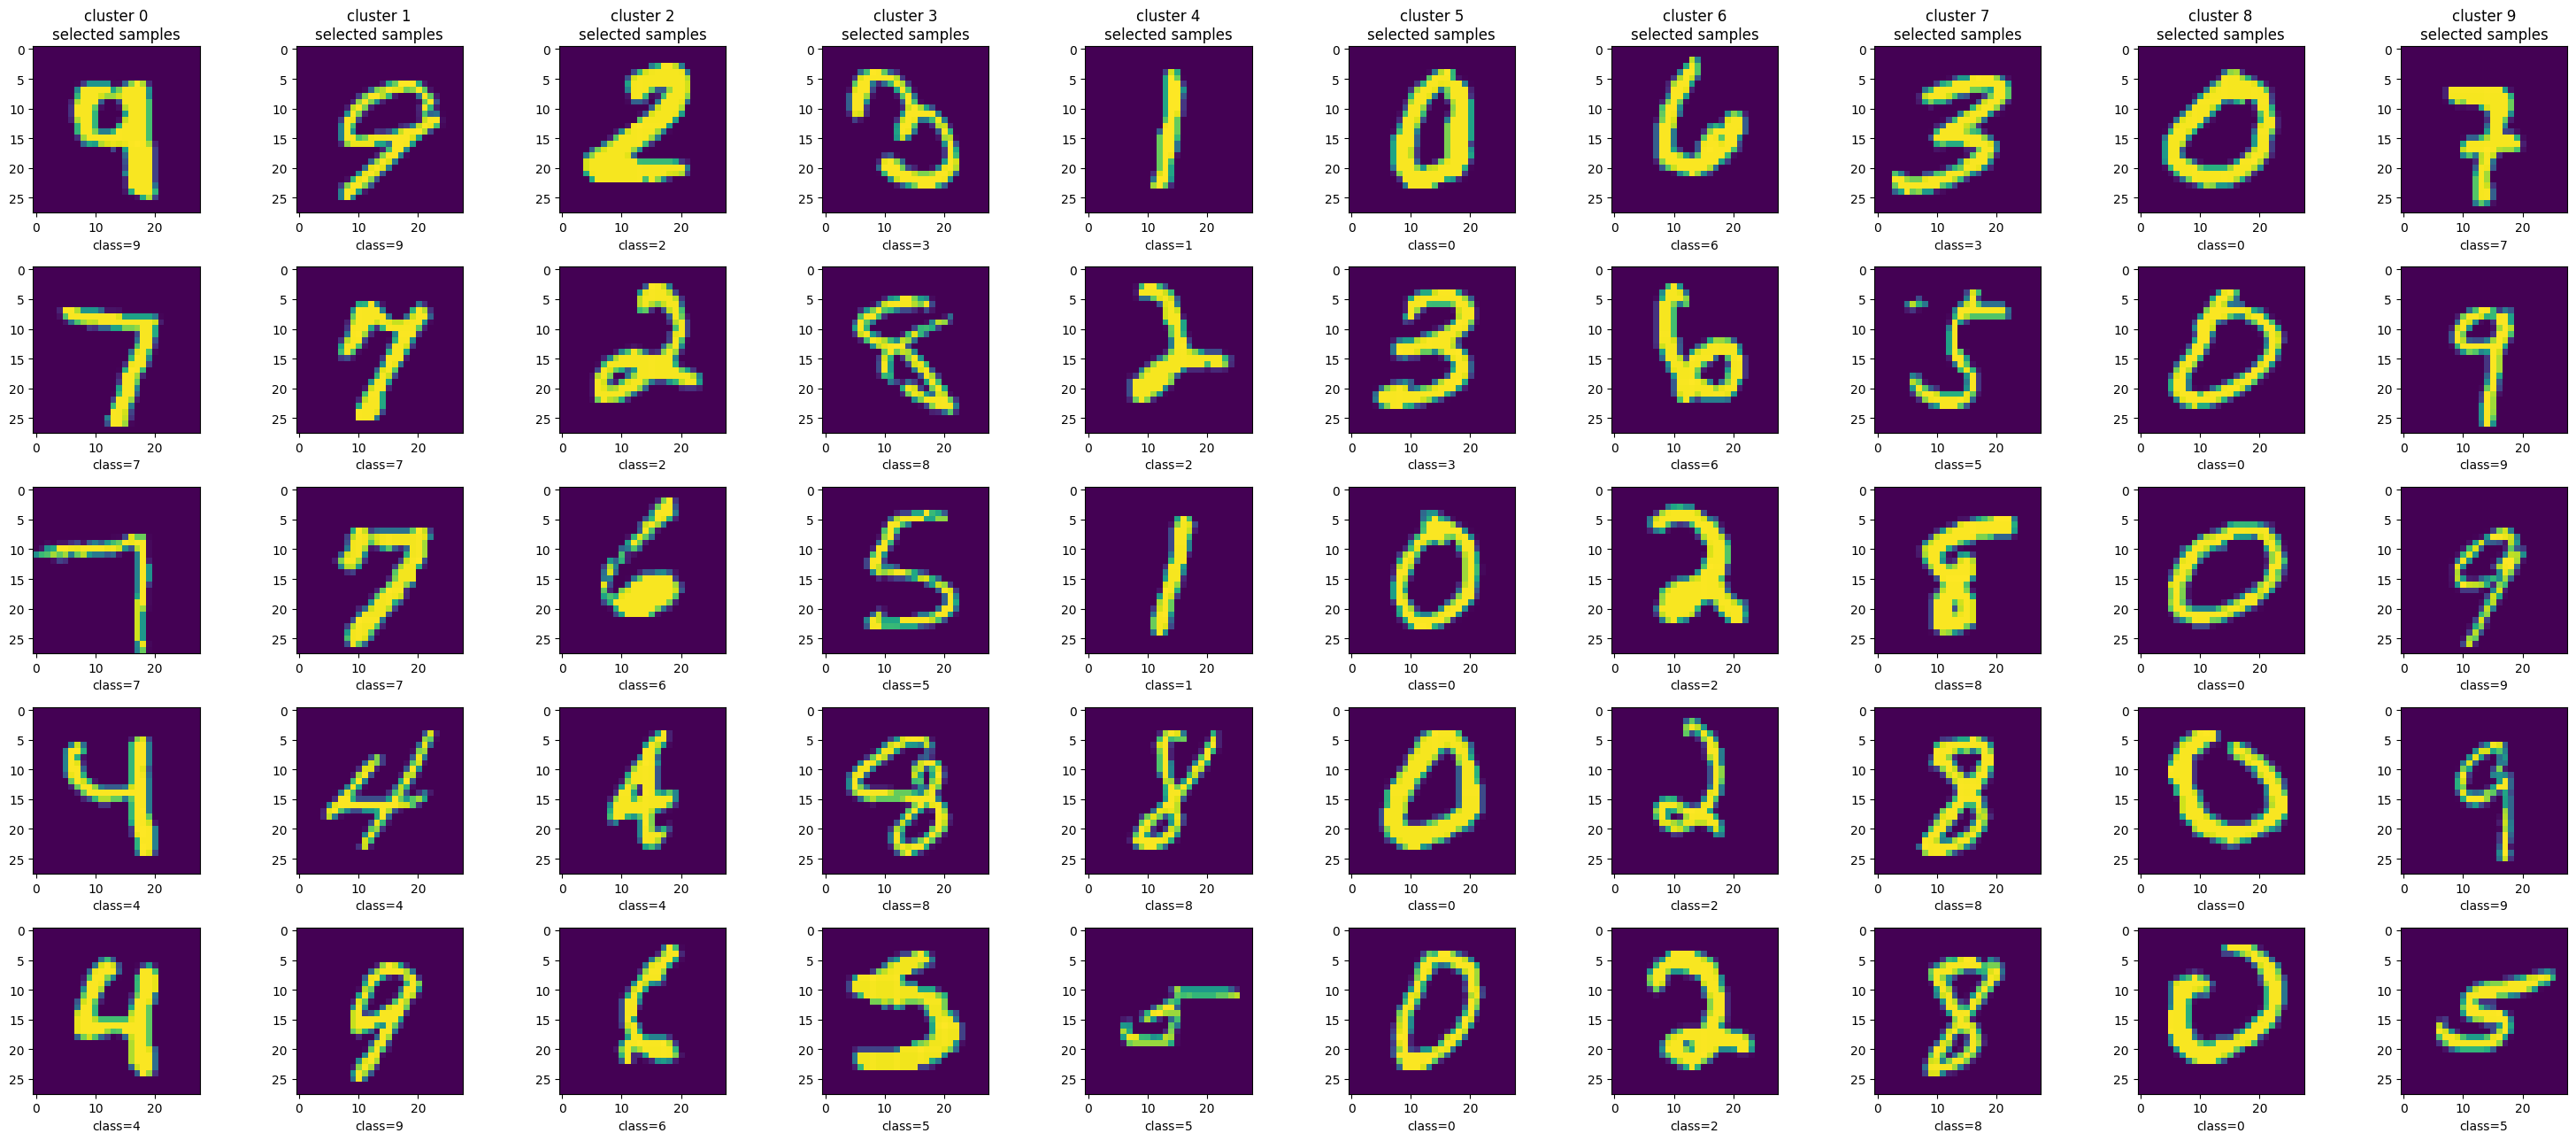

For n_clusters = 10 The average silhouette_score is : 0.057107587669277926


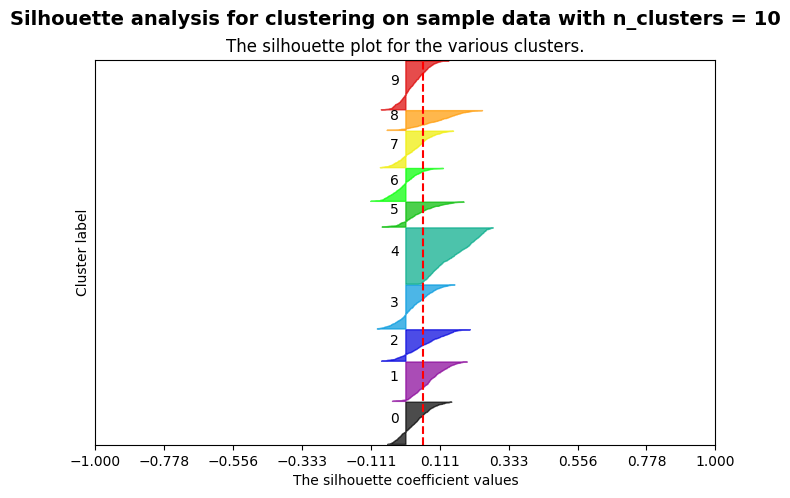

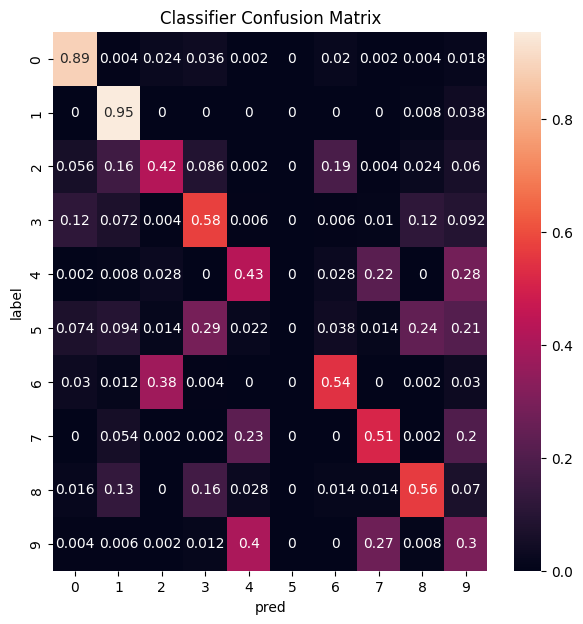

In [15]:
mb_kmeans = MiniBatchKMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=3)
run_experiment(mb_kmeans, train_X, train_y, verbose=True)


In [16]:
for exp in range(12):
    print('batch size: ', 2 ** exp)
    mb_kmeans = MiniBatchKMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=3, batch_size=2 ** exp)
    run_experiment(mb_kmeans, train_X, train_y)
    print('')

batch size:  1
classification report:
               precision    recall  f1-score   support

           0       0.83      0.49      0.61       500
           1       0.12      1.00      0.22       500
           2       0.00      0.00      0.00       500
           3       0.00      0.00      0.00       500
           4       0.00      0.00      0.00       500
           5       0.00      0.00      0.00       500
           6       0.87      0.24      0.38       500
           7       0.90      0.58      0.71       500
           8       0.49      0.04      0.08       500
           9       0.47      0.09      0.15       500

    accuracy                           0.24      5000
   macro avg       0.37      0.24      0.21      5000
weighted avg       0.37      0.24      0.21      5000

clusters labels assignments:
 {0: 6, 1: 9, 2: 7, 3: 1, 4: 8, 5: 0, 6: 0, 7: 6, 8: 8, 9: 0}

batch size:  2
classification report:
               precision    recall  f1-score   support

           0    

<br></br>
## Part 2: Dimensionality reduction

In [17]:
def run_dim_reduction_experiment(model, X, y, verbose=False):
    model_name = model.__class__.__name__
    reduced_X = model.fit_transform(flatten(X))
    if verbose:
        assert model.n_components == 2
        _, ax = plt.subplots(1, 1, figsize=(8, 5))
        sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=train_y, ax=ax)
        ax.set(title=f'{model_name} dim reduction colored by MNIST labels')

    lr = LogisticRegression()
    lr.fit(reduced_X, y)
    pred = lr.predict(reduced_X)
    print(f'{model_name}-based classification results:\n', classification_report(y, pred))

    return reduced_X, lr

PCA-based classification results:
               precision    recall  f1-score   support

           0       0.65      0.74      0.70       500
           1       0.75      0.98      0.85       500
           2       0.22      0.13      0.16       500
           3       0.47      0.49      0.48       500
           4       0.39      0.39      0.39       500
           5       0.15      0.05      0.07       500
           6       0.35      0.31      0.33       500
           7       0.39      0.62      0.48       500
           8       0.24      0.40      0.30       500
           9       0.41      0.19      0.26       500

    accuracy                           0.43      5000
   macro avg       0.40      0.43      0.40      5000
weighted avg       0.40      0.43      0.40      5000



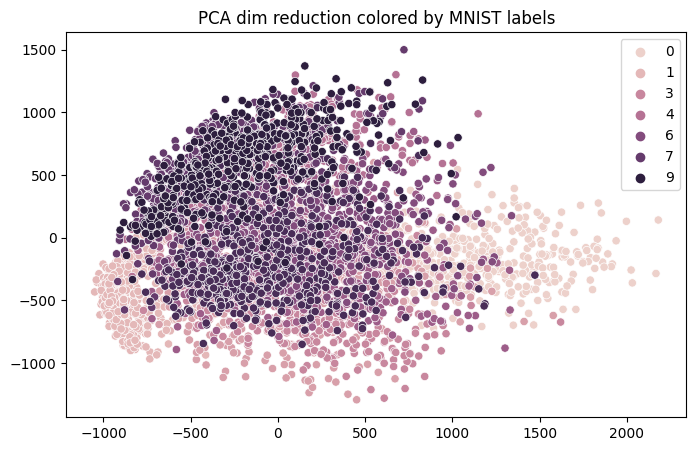

In [18]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
run_dim_reduction_experiment(pca, train_X, train_y, True);

TSNE-based classification results:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       500
           1       0.87      0.87      0.87       500
           2       0.98      0.92      0.95       500
           3       0.86      0.86      0.86       500
           4       0.46      0.43      0.45       500
           5       0.90      0.89      0.89       500
           6       0.96      0.96      0.96       500
           7       0.80      0.91      0.85       500
           8       0.78      0.83      0.81       500
           9       0.44      0.40      0.42       500

    accuracy                           0.81      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.81      0.80      5000



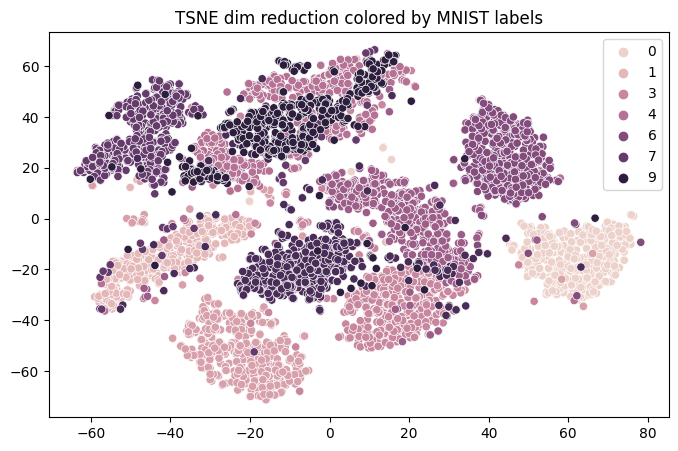

In [19]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
run_dim_reduction_experiment(tsne, train_X, train_y, True);

UMAP-based classification results:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       500
           1       0.90      0.95      0.93       500
           2       0.99      0.95      0.97       500
           3       0.84      0.89      0.86       500
           4       0.90      0.92      0.91       500
           5       0.90      0.85      0.87       500
           6       0.96      0.97      0.96       500
           7       0.83      0.84      0.83       500
           8       0.88      0.83      0.86       500
           9       0.78      0.76      0.77       500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



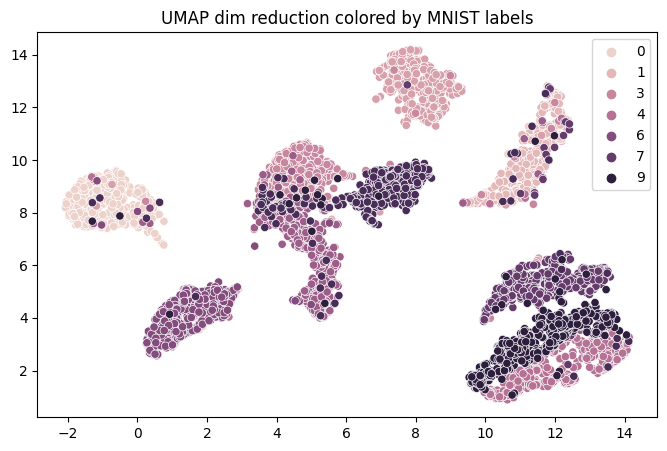

In [20]:
umap = UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=10)
run_dim_reduction_experiment(umap, train_X, train_y, True);

<br></br>
## Part 3: Raw data classification

In [21]:
lr = LogisticRegression(random_state=RANDOM_STATE)
gscv = GridSearchCV(
    estimator=lr,
    param_grid={
        'penalty': ['l1', 'l2'],
        'C': [1, 1e-2, 1e-3]
    },
    cv=5
)
gscv.fit(flatten(train_X), train_y)
print(gscv.best_params_)
pred = gscv.best_estimator_.predict(flatten(test_X))
print('LogisticRegression scores on raw dataset:\n', classification_report(test_y, pred))

{'C': 0.001, 'penalty': 'l2'}
LogisticRegression scores on raw dataset:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       100
           1       0.89      0.97      0.93       100
           2       0.88      0.82      0.85       100
           3       0.88      0.84      0.86       100
           4       0.81      0.88      0.84       100
           5       0.82      0.83      0.83       100
           6       0.93      0.89      0.91       100
           7       0.89      0.89      0.89       100
           8       0.83      0.75      0.79       100
           9       0.85      0.88      0.87       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

